In [9]:
#imports and setup
import pandas as pd
import json
import matplotlib
import matplotlib.pyplot as plt
import easymoney as em
from easymoney.money import EasyPeasy
ep = EasyPeasy()

%matplotlib inline  

In [17]:
#Load up data
ws = pd.read_csv('../datasets/final/cws_violations_p_year_w_demo.csv')
med_inc = pd.read_csv('../datasets/raw/income/national/usa_median_hh_income.csv')
adjusted_inc = pd.DataFrame(columns=['year', 'median_hh_income'])

In [18]:
#Adjust national median income to 2015 dollars
for i, inc in enumerate(med_inc.itertuples()):
    _year = getattr(inc, 'year')
    _inc = getattr(inc, 'median_hh_income')
    _2015_dollars = ep.normalize(amount=_inc, region="USA", from_year=_year, to_year=2015)
    adjusted_inc.set_value(i, 'year', _year)
    adjusted_inc.set_value(i, 'median_hh_income', _2015_dollars)

adjusted_inc = adjusted_inc.set_index('year')
adjusted_inc.head()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys


,median_hh_income
year,
1982,41351.2
1983,41261.6
1984,44912.1
1985,45702
1986,47279.6


In [19]:
#Filter average violations according to these demographic definitions:
# rural = <16 units per square mile sub-urban = 16–380.7 urban => 380.7
# low income is below 75% of national median household income.

# ws = ws.dropna()
rural_low_income = {}
rural_high_income = {}
suburban = {}
urban = {}

years = range(1982, 2016)

for year in years:
    
    income_thresh = .75 * adjusted_inc.loc[(year)]['median_hh_income']
    
    #rural high income
    rhi = ws[((ws['median_hh_income'] >= income_thresh) & (ws['housing_unit_density'] < 16) & (ws['year'] == year))]
    rhi_obs = len(rhi.index)
    rhi_tot = rhi['total_violations'].sum()
    rural_high_income[str(year)] = rhi_tot / rhi_obs
    
    #rural low income
    rli = ws[((ws['median_hh_income'] < income_thresh) & (ws['housing_unit_density'] < 16) & (ws['year'] == year))]
    rli_obs = len(rli.index)
    rli_tot = rli['total_violations'].sum()
    rural_low_income[str(year)] = rli_tot / rli_obs
    
    #suburban
    sub = ws[(ws['housing_unit_density'] >= 16) & (ws['housing_unit_density'] < 380.7) & (ws['year'] == year)]
    sub_obs = len(sub.index)
    sub_tot = sub['total_violations'].sum()
    suburban[str(year)] = sub_tot / sub_obs
    
    #urban
    urb = ws[(ws['housing_unit_density'] > 380.7) & (ws['year'] == year)]
    urb_obs = len(urb.index)
    urb_tot = urb['total_violations'].sum()
    urban[str(year)] = urb_tot / urb_obs

In [21]:
#Export 
with open('../datasets/final/time_trends/rural_low_income.json', 'w') as out:
    json.dump(rural_low_income, out)

with open('../datasets/final/time_trends/rural_high_income.json', 'w') as out:
    json.dump(rural_high_income, out)

with open('../datasets/final/time_trends/suburban.json', 'w') as out:
    json.dump(suburban, out)

with open('../datasets/final/time_trends/urban.json', 'w') as out:
    json.dump(urban, out)

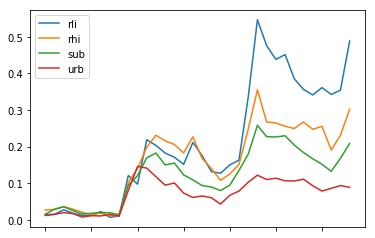

In [26]:
#Graph to see results
rural_low_income_df = pd.DataFrame(rural_low_income, index=[0]).transpose()
rural_high_df = pd.DataFrame(rural_high_income, index=[0]).transpose()
suburban_df = pd.DataFrame(suburban, index=[0]).transpose()
urban_df = pd.DataFrame(urban, index=[0]).transpose()

ax = rural_low_income_df.plot()
rural_high_df.plot(ax=ax)
suburban_df.plot(ax=ax)
urban_df.plot(ax=ax)
ax.legend(['rli', 'rhi', 'sub', 'urb'])